Text(0.5, 0, 'Time (sec)')

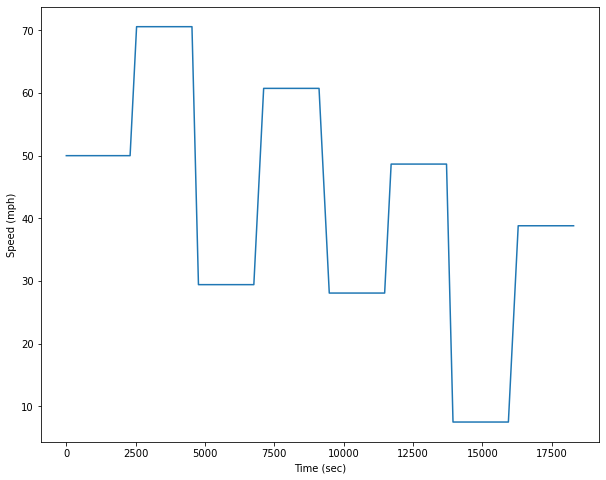

In [7]:
dt = 0.0166666666666667
#dt = 0.04
duration = 1000
m2m = 1/2.2369
#duration = 200
v0 = 50*m2m*np.ones(2300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(int(146*2.5)):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))


plt.figure(figsize=(10,8))
plt.plot(v0/m2m)
plt.ylabel('Speed (mph)')
plt.xlabel('Time (sec)')

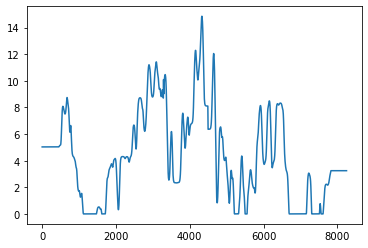

In [103]:
dt = 1/60
duration = 2000
m2m = 1/2.2369
v18na = np.loadtxt('na_speed_18mph.txt')
a18na = np.diff(v18na)/0.1
a18na = np.append(0,a18na)
for i in range(len(a18na)):
    if a18na[i]>5:
        a18na[i] = 5
    elif a18na[i]<-6:
        a18na[i] = -6
        
#plt.plot(a18na)
v18new = np.zeros(a18na.shape)
v18new[0] = v18na[0]
for i in range(1,len(v18new)):
    v18new[i] = v18new[i-1] + 0.1*a18na[i]*1.3
v18new = v18new/m2m-13
for i in range(1,len(v18new)):
    if v18new[i]<0:
        v18new[i] = 0
v0 = v18new[750:2050]

x = np.linspace(0, v0.shape[0], v0.shape[0])
x1 = np.linspace(0, v0.shape[0], v0.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v0)
v01 = vinterp(x1)
v01 = np.append(v01[0]*np.ones(450), v01)
plt.plot(v01)

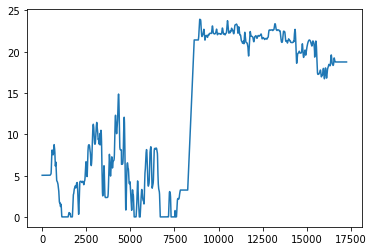

In [104]:
v48na = np.loadtxt('na_speed_48mph.txt')
a48na = np.diff(v48na)/0.1
a48na = np.append(0,a48na)

v48new = np.zeros(a48na.shape)
v48new[0] = v48na[0]
for i in range(1,len(v48new)):
    v48new[i] = v48new[i-1] + 0.1*a48na[i]*1
v00 = v48new[160:1600]

x = np.linspace(0, v00.shape[0], v00.shape[0])
x1 = np.linspace(0, v00.shape[0], v00.shape[0]*6)
from scipy.interpolate import interp1d
vinterp = interp1d(x, v00)
v001 = vinterp(x1)

#plt.plot(v001)

dt = 1/60
v_run0 = v01
for i in range(363):
    v_run0 = np.append(v_run0, v_run0[-1]+3*dt)
v_run0 = np.append(v_run0, v001)
plt.plot(v_run0)

## NA

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 2000
m2m = 1/2.2369
v48na = np.loadtxt('run0_NA.txt')
v01 = v48na
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 4, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v01
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))
timeInst = []

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2
a0=0.67
b0=1.73
T=2.5
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33.3
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma) + 4
v_len = 5

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

#dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')
    
    
    t = datetime.now()
    timeInst.append(t.strftime("%m/%d/%Y-%H:%M:%S.%f")[:-3])

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < 4:
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    #print(vy, vx)        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run0_pos_na.txt', position)
        np.savetxt('./run0_pos_na.txt', speed)
        np.savetxt('./run0_accel_na.txt', accel)
        np.savetxt('./run0_pos_na_ego.txt', pos_ego)
        np.savetxt('./run0_vel_na_ego.txt', vel_ego)
        np.savetxt('./run0_acc_na_ego.txt', acc_ego)
        
        with open('run0_na_timeStance.txt', 'w') as output:
            output.write(str(timeInst))
        break

traci.close()

KeyboardInterrupt: 

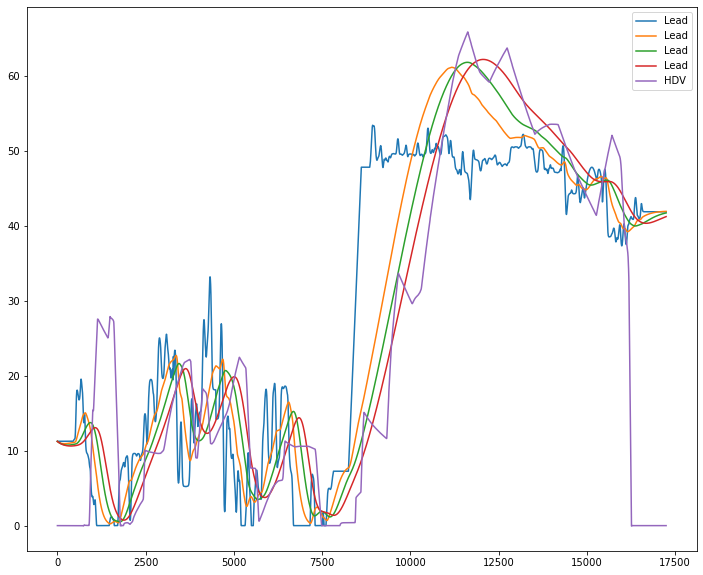

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1:N_lane_0+N_lane_1+N_lane_2])/m2m, label='Lead')
#plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()

## Trapezoid

In [1]:
import os, sys, socket, re, json, random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

def acc_linear(h, v, space, rel_v, rel_a, ks, kv, ka):
    return ks*(space-h*v) + kv*rel_v + ka*rel_a

h = 0.75
ks, kv, ka = 8, 2, 0.1

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")

#sumoBinary = os.path.join(os.environ['SUMO_HOME'], 'bin/sumo-gui')
#sumoCmd = [sumoBinary, "-c", "longhighway.sumo.cfg", "--start"]

import traci
import sumolib
from sumolib import checkBinary
import sumolib.net
from sumolib.net import readNet
from sumolib.net import Net
from sumolib.net import NetReader
from sumolib.net import lane
from sumolib.net import edge
from sumolib.net import node 
from sumolib.net import connection
from sumolib.net import roundabout
from sumolib.net.edge import Edge

##################### Lead Traj ########################
dt = 1/60
duration = 1000
m2m = 1/2.2369

v0 = 50*m2m*np.ones(2300)
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(int(146*2.5)):
    v0 = np.append(v0, v0[-1]-1*dt*(0.04/dt))

v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(230):
    v0 = np.append(v0, v0[-1]-2*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*2))
for i in range(350):
    v0 = np.append(v0, v0[-1]+1*dt*(0.04/dt))
v0 = np.append(v0, v0[-1]*np.ones(duration*3))
########################## Parameters of platoon ##########################
N_lane_0, N_lane_1, N_lane_2, N_lane_3 = 10, 10, 4, 1

N_VEHICLES = N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3

lead_v = v0
lead_a = np.diff(lead_v)/dt
lead_a = np.append(0, lead_a)

# used to randomly color the vehicles
random.seed(1)
step = 0

max_iter = len(lead_a)*1
#max_iter = 2
#print(max_iter)

position = np.zeros((max_iter+1, N_VEHICLES))
pos_ego = np.zeros((max_iter+1,))
vel_ego = np.zeros((max_iter+1,))
acc_ego = np.zeros((max_iter+1,))
speed = np.zeros((max_iter+1, N_VEHICLES))
accel = np.zeros((max_iter+1, N_VEHICLES))
light = np.zeros((max_iter+1, N_VEHICLES))
timeInst = []

def EIDM(spacing, v, v0, s0=3, a0=1.8, b0=2.8, T=1, sigma=4, Kf=1, Kg=0.6, *cv_arg):

    cv_arg = cv_arg[0]
    CAV_count = len(cv_arg)//2
    temp_v, temp_a = 0, 0
    alpha, beta = np.zeros((1,CAV_count)), np.zeros((1,CAV_count))
    if CAV_count > 0:
        for i in range(CAV_count):
            alpha[i] = 0.3/(0.3+np.exp(i))
            beta[i] = 0.3/(0.3+np.exp(i))
            temp_v += alpha[i]*cv_arg[2*i]
            temp_a += beta[i]*cv_arg[2*i+1]
        #s_star = s0 + v*T - v*alpha[0]*cv_arg[0]/(2*np.sqrt(a0*b0))
        s_star = s0 + v*T - v*cv_arg[0]/(2*np.sqrt(a0*b0))
    else:
        print('Error because no CAV speed and acceleration input!')
    a_free = a0*(1-(v/v0)**sigma)
    a_int = -a0*(s_star/spacing)**2
    acc = a_free + a_int
    
    return Kf*acc + Kg*(temp_v + temp_a)

#SS
s0=2
a0=0.7
b0=1.7
T=2.5
sigma=4
Kf=1
Kg=0

length = 5
spd = lead_v[0]
v0 = 33.3
dis = (s0+spd*T)/np.sqrt(1-(spd/v0)**sigma) + 4
v_len = 5

# SS
#h = 1
#ks, kv, ka = 2, 2, 1

#dis = spd*h + 4
#dis = 45
#########################################################################

graph = sumolib.net.readNet('LLC.net.xml', withInternal=True) #internal edge are edges inside interseciton or connections 
vertex = graph.getNodes()
edge = graph.getEdges(withInternal=True)
#print('edge length:')
#print(len(edge))

sumoCmd = [sumolib.checkBinary('sumo-gui'), '-c', 'LLC_SUMO_no.sumo.cfg']
traci.start(sumoCmd)
step = 0

traci.route.add(routeID = 'route1', edges = ['-17.0.00'])
#traci.vehicle.add('ego', "route")
traci.vehicle.add('ego', "route1", departPos=str(500), departSpeed=str(spd), departLane = str(2), typeID="passenger")
traci.vehicle.setColor('ego', color=(255, 0, 0, 255))
traci.vehicle.setLaneChangeMode('ego', 256)
#print(traci.vehicle.getRoadID('ego'))
#print(traci.vehicle.getPosition('ego'))
#print(traci.vehicle.getLanePosition('ego'))

#UDP_IP = "192.168.0.11"
UDP_IP = "192.168.0.181"
UDP_PORT = 23333

serverSock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
serverSock.bind((UDP_IP, UDP_PORT))

data, address = serverSock.recvfrom(1024*6)
data = data.decode('utf-8').split("$")[0]

y, x, z, vx, vy = data.split(";")
#x, y = '6448.97', '-6645.57'
X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
eEdge = traci.vehicle.getRoadID('ego')
ePos = traci.vehicle.getPosition('ego')
traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)


X_offset, Y_offset = 814.72, 0.55
traci.simulationStep()

def dis_ego(vID_tmp):
    posi = traci.vehicle.getPosition(vID_tmp)
    dis = ((ePos[0] - posi[0])**2 + (ePos[1] - posi[1])**2)**(1/2)
    return dis
    
while step<=max_iter:

    data, address = serverSock.recvfrom(1024*6)
    data = data.decode('utf-8').split("$")[0]
    y, x, z, vx, vy = data.split(";")
    #x, y = '6448.97', '-6645.57'
    X_offset, Y_offset = 814.72, 0.55  #882.504, 846.15
    x, y, z = X_offset+float(x.replace("\x00", "")), Y_offset+float(y.replace("\x00", "")), float(z.replace("\x00", ""))*180/3.14159265
    vx, vy = float(vx.replace("\x00", "")), float(vy.replace("\x00", ""))
    eEdge = traci.vehicle.getRoadID('ego')
    ePos = traci.vehicle.getPosition('ego')
    traci.vehicle.moveToXY('ego', '', 0, x, y, angle=z, keepRoute=2)
    #traci.vehicle.setSpeed('ego', 0.0)
    eLanePos = traci.vehicle.getLanePosition('ego')
    #pint(eLanePos)
    pos_ego[step] = eLanePos
    #vel_ego[step] = np.sqrt(vx**2+vy**2)
    vel_ego[step] = vx
    if step==0:
        acc_ego[step] = 0
    else:
        acc_ego[step] = (vel_ego[step]-vel_ego[step-1])/dt

    eLanePos = traci.vehicle.getLanePosition('ego')
    
    t = datetime.now()
    timeInst.append(t.strftime("%m/%d/%Y-%H:%M:%S.%f")[:-3])

    if step==0:
        #eLanePos = 10
        for i in range(N_VEHICLES):
            if i < N_lane_0:
                position[0, i] = eLanePos + (N_lane_0-i)*dis + 5 - dis*N_lane_0//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(0), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            elif i >= N_lane_0 and i < N_lane_0 + N_lane_1:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1-i)*dis + 2 - dis*N_lane_1//2
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(1), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            elif i >= N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                position[0, i] = eLanePos + (N_lane_0+N_lane_1+N_lane_2-i)*dis + 8
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
                
            else:
                position[0, i] = eLanePos - dis - 5
                speed[0, i] = spd
                accel[0, i] = 0
                
                vid = "%d" % i
                traci.vehicle.add(vid, "route1", departPos=str(position[0, i]), departSpeed=str(spd), departLane = str(2), typeID="vtypeauto")
                traci.vehicle.setColor(vid, (random.uniform(0, 255), random.uniform(0, 255), random.uniform(0, 255), 255))
                traci.vehicle.setLaneChangeMode(vid, 256)
            
            traci.gui.trackVehicle("View #0", "%d" % i)
            traci.gui.setZoom("View #0", 3000)
            
    elif step>=1:
        if True:
            for i in range(N_VEHICLES):
                if i == 0 or i == N_lane_0 or i == N_lane_0+N_lane_1:                  
                    accel[step,i] = lead_a[step//1]
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    if i == 0:
                        lane_idx = 0
                    elif i == N_lane_0:
                        lane_idx = 1
                    elif i == N_lane_0+N_lane_1:
                        lane_idx = 2
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    if lead_a[step//1]< -0.2:
                        traci.vehicle.setSignals("%d" % i, 3)
                    else:
                        traci.vehicle.setSignals("%d" % i, 0)
                        
                else:
                    if i < N_lane_0:
                        #space = traci.vehicle.getLanePosition("v.%d" % (i-1)) - traci.vehicle.getLanePosition("v.%d" % i)
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        #v = traci.vehicle.getSpeed("v.%d" % i)
                        v = speed[step-1,i]
                        #rel_v = traci.vehicle.getSpeed("v.%d" % (i-1)) - traci.vehicle.getSpeed("v.%d" % i)
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        #rel_acc = traci.vehicle.getAcceleration("v.%d" % (i-1))- traci.vehicle.getAcceleration("v.%d" % i)
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 0
                    elif i > N_lane_0 and i < N_lane_0 + N_lane_1:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 1
                    elif i > N_lane_0 + N_lane_1 and i < N_lane_0 + N_lane_1 + N_lane_2:
                        space = position[step-1,i-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = speed[step-1,i-1] - speed[step-1,i]
                        rel_acc = accel[step-1,i-1] - accel[step-1,i]
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        lane_idx = 2
                    else:
                        space = pos_ego[step-1] - position[step-1,i] - v_len
                        v = speed[step-1,i]
                        rel_v = vel_ego[step-1] - speed[step-1,i]
                        rel_acc = acc_ego[step-1] - accel[step-1,i]
                        #acceleration = acc_linear(h, v, space, rel_v, rel_acc, ks, kv, ka)
                        acceleration = EIDM(space, v, v0, s0, a0, b0, T, sigma, Kf, Kg, (rel_v,rel_acc))
                        lane_idx = 2
                    
                    if i== N_lane_0 + N_lane_1 + N_lane_2 + N_lane_3 - 1 and space < 4:
                        acceleration = -8
                    elif space < (speed[step-1,i]**2 - speed[step-1,i-1]**2)/(2*8):
                        acceleration = -8
                    accel[step,i] = acceleration
                    speed[step,i] = speed[step-1,i] + accel[step,i]*dt
                    position[step,i] = position[step-1,i] + speed[step,i] * dt
                    traci.vehicle.moveTo("%d" % i, '-17.0.00_'+str(lane_idx), position[step,i])
                    
                    #traci.vehicle.setSpeed("%d" % i, speed[step,i] + acceleration*dt)
                    drag_decel = -0.25   #0.12 + (0.25*(speed[step,i] + acceleration*dt)**2)/1750
                    if acceleration < drag_decel:
                        light[step,i] = 3
                        traci.vehicle.setSignals("%d" % i, 0)
                    else:
                        light[step,i] = 0                            
                        traci.vehicle.setSignals("%d" % i, 0)
    

    #print(traci.vehicle.getPosition('ego'))
    #print(traci.vehicle.getLanePosition('ego'))
    #print(traci.vehicle.getSpeed('11'), traci.vehicle.getAcceleration('11'))
    Message=''
    Message =  "0" + "," + "0" + "," + str(step)+ "," + Message
    for k in range(N_VEHICLES):
        vID = str(k)
        
        Position = traci.vehicle.getPosition(vID)
        sig = light[step,k]      #sig = traci.vehicle.getSignals(vID)
        vel = speed[step,k] #traci.vehicle.getSpeed(vID)

        #if (Position[0]-x)**2 + (Position[1]-y)**2 > 90000:
        #        continue
        Message += str(vID)+","

        #xx = "{0:.3f}".format(position[0]-x) 
        xx = "{0:.3f}".format(Position[0]-X_offset) 

        #yy = "{0:.3f}".format(position[1]-y) 
        yy = "{0:.3f}".format(Position[1]-Y_offset) 

        Message += xx + "," + yy +","
        #print(vID,Position[0],Position[1])
        #print(vID,xx,yy)
        angle = traci.vehicle.getAngle(vID)
        angle = "{0:.3f}".format(angle) 
        Message += angle + ","
        
        Message +=  str(sig) + "," + str(vel) + ","

    Message = Message[:-1]
    #print(repr(Message))
    serverSock.sendto(Message.encode('utf-8'), (address[0], 23334))

    step += 1

    #for i in range(N_VEHICLES):
    #    position[step,i] = traci.vehicle.getLanePosition("%d" % i)
    #    speed[step,i] = traci.vehicle.getSpeed("%d" % i)
    #    accel[step,i] = traci.vehicle.getAcceleration("%d" % i)
        #light[step,i] = traci.vehicle.getSignals("%d" % i)
    #print(vy, vx)        

    #plt.plot(speed[max(0,step-1000):step,N_lane_0 + N_lane_1])
    #print(traci.vehicle.getSpeed(str(N_lane_0 + N_lane_1)))
    traci.simulationStep()
    if step >= max_iter-1:
        np.savetxt('./run0_pos_trap.txt', position)
        np.savetxt('./run0_pos_trap.txt', speed)
        np.savetxt('./run0_accel_trap.txt', accel)
        np.savetxt('./run_pos_trap_ego.txt', pos_ego)
        np.savetxt('./run_vel_trap_ego.txt', vel_ego)
        np.savetxt('./run_acc_trap_ego.txt', acc_ego)
        
        with open('run0_trap_timeStance.txt', 'w') as output:
            output.write(str(timeInst))
        break

traci.close()

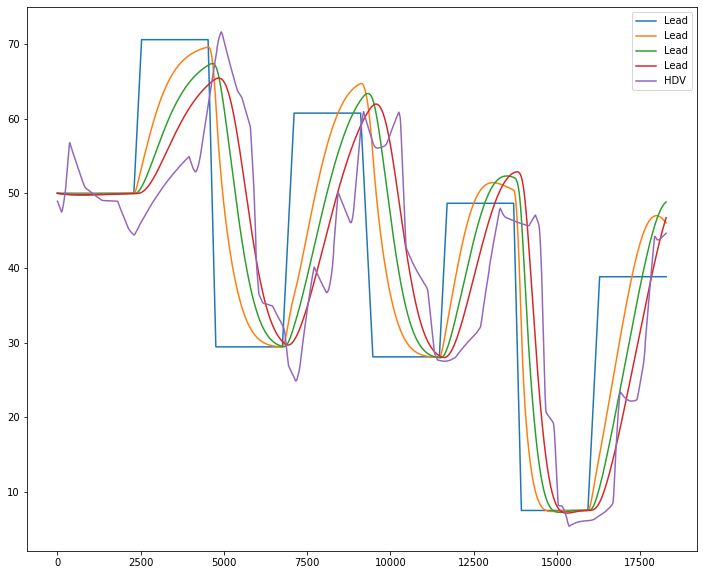

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.plot((speed[3:step//1,N_lane_0+N_lane_1:N_lane_0+N_lane_1+N_lane_2])/m2m, label='Lead')
#plt.plot((speed[3:step//1,N_lane_0+N_lane_1+1])/m2m, label='Mid')
plt.plot(vel_ego[3:step//1]/m2m, label='HDV')
plt.legend()
#plt.xlim([4000,12000])
#plt.ylim([40,60])

In [4]:
len(speed)//60

304